In [1]:
%run "../LOS.ipynb"

In [2]:
#import os
#from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine
from decouple import config 
from dotenv import load_dotenv
#import pandas as pd
#from numpy import int16
#from enum import Enum

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("max_columns",None)


In [3]:
load_dotenv()
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = f'''
    SELECT 
    gb.* 
    FROM caris_db.gardening_beneficiary gb 
    where  
    gb.beneficiary_type ='dreams'
'''

gbd = pd.read_sql_query(query,engine,parse_dates=True)
# get the test excel file from Query

# close the pool of connection
engine.dispose()

True

In [6]:
gbd.to_excel("data_gardens.xlsx",index=False,na_rep="NULL")
df = dreams_mastersheet

cohorte = df[
    (df.age_range != "25-29")&
    (df.age_range != "not_valid_age")&
    (df.timeOn_system=="required_Time_on")
]


jardinage = df[
    (df.age_range != "25-29")&
    (df.age_range != "not_valid_age")&
    (df.timeOn_system=="required_Time_on")&
    (df.is_gardening=="yes")
]

cohorte.code.count()
gbd.case_id.count()
jardinage.code.count()

18910

1460

321

In [24]:
jardinage.pivot_table(index="age_range",columns="fiscal_year",
                        values='code',
                        aggfunc='count',
                        fill_value=0,
                        margins=True,
                        margins_name="Grand Total"                             
)
#lgb_old = pd.read_excel("liste_filles_dreams_eligibles_jardinage_24Mai2021.xlsx")
#lgb_old.code.count()

fiscal_year,Q3fy20-Q4fy20,Grand Total
age_range,,
10-14,120,120
15-19,119,119
20-24,82,82
Grand Total,321,321


# Radicial MOVE

In [9]:
garden_served = pd.read_excel("./Gardening_AGYW_served_From April 2020.xlsx",sheet_name="Filles_Dreams_From_April_2020")
garden_served.code_dreams.fillna("NULL",inplace=True)
#garden_served.code_dreams = garden_served.code_dreams.str.upper()
garden_served.code_dreams.count()

In [11]:
garden_served["validation_code_dreams"]= garden_served.code_dreams.str.fullmatch("^[A-Z]{3}/DRMS/(\d{9})$")
garden_served.rename(columns={'info.owner_name':'username'},inplace=True)
code_occurence = garden_served.groupby("code_dreams").count()[["username"]]
code_occurence.reset_index(inplace=True)
code_occurence.rename(columns={'username':"code_occurence"},inplace=True)


lookup_garden = pd.read_excel("lookup_gardening.xlsx")
lookup_garden.rename(columns={'name':'agent_name'},inplace=True)


garden_served_complete =  lookup_garden.merge(garden_served,on='username',how='right')
garden_served_complete = garden_served_complete.merge(code_occurence,on='code_dreams',how="right")

In [17]:
#garden_served_complete[
#    (garden_served_complete.code_occurence!=1)&
#    (garden_served_complete.code_occurence!=len(garden_served_complete[garden_served_complete.code_dreams == 'NULL'][['username']]))&
#    (garden_served_complete.code_occurence!=len(garden_served_complete[garden_served_complete.code_dreams == '---'][['username']]))
#]
all_duplicated = garden_served_complete[(~garden_served_complete.code_dreams.isin(['---','NULL']))&(garden_served_complete.code_occurence!=1)]


code_non_standard = garden_served_complete[(~garden_served_complete.code_dreams.isin(['---','NULL']))&(garden_served_complete.validation_code_dreams == False)]

In [19]:
all_report = pd.ExcelWriter(f"validation_garden.xlsx",engine="xlsxwriter")
garden_served_complete.to_excel(all_report,sheet_name="table_global",index=False,na_rep="NULL")
all_duplicated.to_excel(all_report,sheet_name="les_duplications",index=False,na_rep="NULL")
code_non_standard.to_excel(all_report,sheet_name="codes_non_standards",index=False,na_rep="NULL")
all_report.save()

## Visual data from excel pivot tables - validation_garden

In [20]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'Les duplications observees dans les codes dreams des beneficiaires Jardinages')

Text(0.0, 32.0, '64')

Text(1.0, 26.0, '52')

Text(2.0, 6.0, '12')

Text(-80, -20, 'source: HIVHaiti')

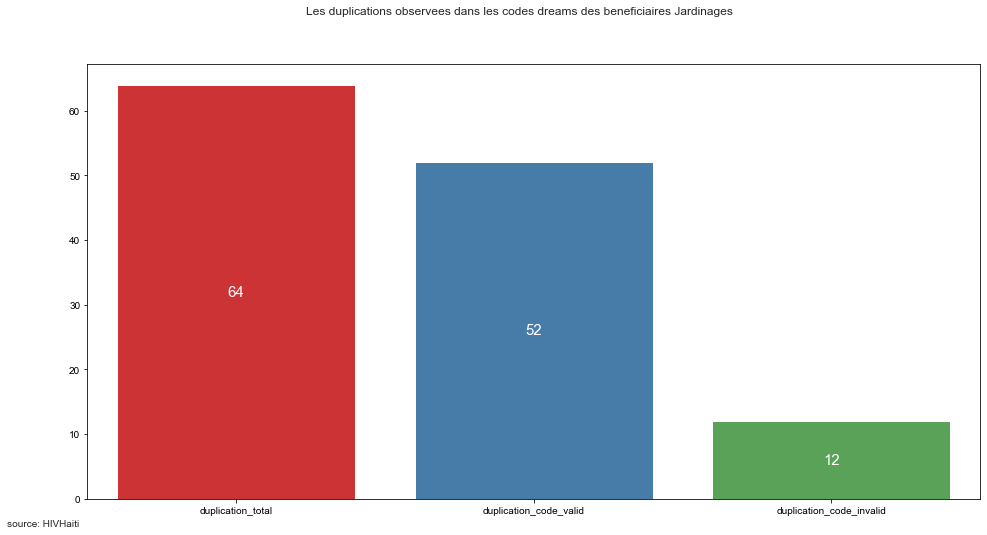

In [21]:
duplication_plot = pd.DataFrame({"state":["duplication_total","duplication_code_valid","duplication_code_invalid"],
                            "data": [64,52,12]                        
})

plt.subplots(figsize=(16,8))
sns.set_style("darkgrid")
sns.set_palette("Set1")
splot = sns.barplot(x="state",y="data",data=duplication_plot)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("Les duplications observees dans les codes dreams des beneficiaires Jardinages")
for p in splot.patches:
    height = p.get_height()
    plt.text(
                p.get_x() + p.get_width()/2, 
                0.5*p.get_height() + p.get_y(),
                '{:1.0f}'.format(height), 
                ha='center', va='center',
                size=15,
                fontdict=dict(color="white",fontsize=15)
            )
    
plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)
plt.savefig("all_garden_duplicate",dpi=1000)

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'La situation global des code dreams pour les beneficiaires Jardinages')

Text(0.0, 730.0, '1460')

Text(1.0, 525.5, '1051')

Text(2.0, 204.5, '409')

Text(3.0, 32.0, '64')

Text(-80, -20, 'source: HIVHaiti')

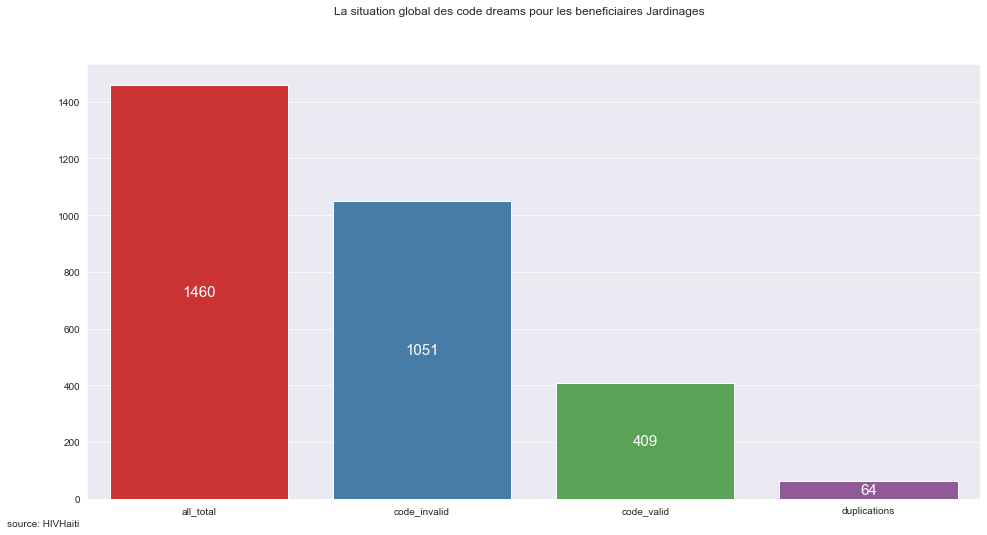

In [22]:
garden_plot = pd.DataFrame({"state":["all_total","code_invalid","code_valid","duplications"],
                            "data": [1460,1051,409,64]                        
})

plt.subplots(figsize=(16,8))
sns.set_style("darkgrid")
sns.set_palette("Set1")
splot = sns.barplot(x="state",y="data",data=garden_plot)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("La situation global des code dreams pour les beneficiaires Jardinages")
for p in splot.patches:
    height = p.get_height()
    plt.text(
                p.get_x() + p.get_width()/2, 
                0.5*p.get_height() + p.get_y(),
                '{:1.0f}'.format(height), 
                ha='center', va='center',
                size=15,
                fontdict=dict(color="white",fontsize=15)
            )
    
plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)
plt.savefig("all_garden",dpi=1000)

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'La situation des code dreams invalid pour Jardinage')

Text(0.0, 525.5, '1051')

Text(1.0, 225.0, '450')

Text(2.0, 214.5, '429')

Text(3.0, 86.0, '172')

Text(-80, -20, 'source: HIVHaiti')

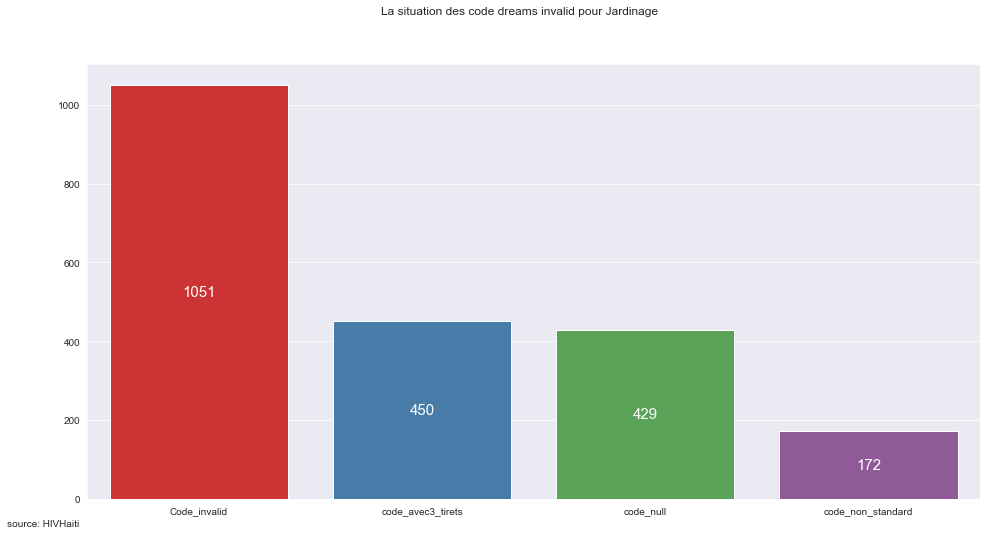

In [23]:
bad_code_plot = pd.DataFrame({"state":["Code_invalid","code_avec3_tirets","code_null","code_non_standard"],
                            "data": [1051,450,429,172]                        
})

plt.subplots(figsize=(16,8))
sns.set_style("darkgrid")
sns.set_palette("Set1")
splot = sns.barplot(x="state",y="data",data=bad_code_plot)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("La situation des code dreams invalid pour Jardinage")
for p in splot.patches:
    height = p.get_height()
    plt.text(
                p.get_x() + p.get_width()/2, 
                0.5*p.get_height() + p.get_y(),
                '{:1.0f}'.format(height), 
                ha='center', va='center',
                size=15,
                fontdict=dict(color="white",fontsize=15)
            )
    
plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)
plt.savefig("garden_invalid",dpi=1000)

# New Verification